In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools as it
from scipy.sparse import coo_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
%matplotlib inline

## Helper functions you don't need to modify

# Function to remove outliers before plotting histogram
def remove_outlier(x, thresh=3.5):
    """
    returns points that are not outliers to make histogram prettier
    reference: https://stackoverflow.com/questions/11882393/matplotlib-disregard-outliers-when-plotting/11886564
    Arguments:
        x {numpy.ndarray} -- 1d-array, points to be filtered
        thresh {float} -- the modified z-score to use as a threshold. Observations with
                          a modified z-score (based on the median absolute deviation) greater
                          than this value will be classified as outliers.
    Returns:
        x_filtered {numpy.ndarray} -- 1d-array, filtered points after dropping outlier
    """
    if len(x.shape) == 1: x = x[:,None]
    median = np.median(x, axis=0)
    diff = np.sqrt(((x - median)**2).sum(axis=-1))
    modified_z_score = 0.6745 * diff / np.median(diff)
    x_filtered = x[modified_z_score <= thresh]
    return x_filtered

## End of helper functions

def create_vandermonde(x,m):
    A = []
    for xi in x:
        temp =[]
        for i in range(0,m+1):
            temp.append(np.power(xi,i))
        
        A.append(temp)
        
    A = np.array(A)
    
    return A    


def solve_linear_LS(A,y):
    R = np.dot(A.transpose(),A)
    p = np.dot(A.transpose(),y)
    
    z_hat = np.linalg.lstsq(R,p,rcond=None)[0]
    
    return z_hat


def solve_linear_LS_gd(A,y,step,niter):
    z_hat = np.zeros(A.shape[1])
    
    for i in range(niter):
        delta = y - np.dot(A,z_hat)
        z_hat = z_hat+step*(np.dot(delta,A))
    
    return z_hat


def extract_and_split(df, d, test_size=0.5):
    data = df.values
    
    x = []
    y = []
    for i in range(data.shape[0]):
        if data[i][1]==d:
            x.append(data[i][0])
            y.append(data[i][1])
    
    x = np.array(x)
    y = np.array(y)
    column = -1*np.ones(x.shape[0])
    x = np.column_stack((x,column))
    
    X_tr,X_te,y_tr,y_te = train_test_split(x,y,test_size=test_size,random_state=5)
    
    return X_tr, X_te, y_tr, y_te  
# Other possibly useful functions
#from sklearn.model_selection import train_test_split
#from sklearn.metrics import accuracy_score, confusion_matrix

def mnist_pairwise_LS(df, a, b, test_size=0.5, verbose=False, gd=False):
    # Find all samples labeled with digit a and split into train/test sets
    Xa_tr, Xa_te, ya_tr, ya_te = extract_and_split(df,a,test_size)
    ya_tr = -1*np.ones(ya_tr.shape[0])
    ya_te = -1*np.ones(ya_te.shape[0])

    # Find all samples labeled with digit b and split into train/test sets
    Xb_tr, Xb_te, yb_tr, yb_te = extract_and_split(df,b,test_size)
    yb_tr = np.ones(yb_tr.shape[0])
    yb_te = np.ones(yb_te.shape[0])

    # Construct the full training set
    X_tr = np.append(Xa_tr,Xb_tr,axis=0)
    y_tr = np.append(ya_tr,yb_tr,axis=0)
    
    # Construct the full testing set
    X_te = np.append(Xa_te,Xb_te,axis=0)
    y_te = np.append(ya_te,yb_te,axis=0)
    
    # Run least-square on training set
    z_hat = solve_linear_LS(X_tr,y_tr)
        
    # Compute estimate and classification error for training set
    y_hat_tr = np.dot(X_tr,z_hat)
    for i in range(y_hat_tr.shape[0]):
        if y_hat_tr[i] <= 0:
            y_hat_tr[i] = -1
        if y_hat_tr[i] > 0:
            y_hat_tr[i] = 1
    
    err_tr = 1-accuracy_score(y_tr,y_hat_tr)
    
    # Compute estimate and classification error for training set
    y_hat_te = np.dot(X_te,z_hat)
    for i in range(y_hat_te.shape[0]):
        if y_hat_te[i] <= 0:
            y_hat_te[i] = -1
        if y_hat_te[i] > 0:
            y_hat_te[i] = 1
            
    err_te = 1-accuracy_score(y_te,y_hat_te)
    
    if verbose:
        print('Pairwise experiment, mapping {0} to -1, mapping {1} to 1'.format(a, b))
        print('training error = {0:.2f}%, testing error = {1:.2f}%'.format(100 * err_tr, 100 * err_te))
        
        # Compute confusion matrix
        cm = np.zeros((2, 2), dtype=np.int64)
        cm[0, 0] = ((y_te == -1) & (y_hat_te == -1)).sum()
        cm[0, 1] = ((y_te == -1) & (y_hat_te == 1)).sum()
        cm[1, 0] = ((y_te == 1) & (y_hat_te == -1)).sum()
        cm[1, 1] = ((y_te == 1) & (y_hat_te == 1)).sum()
        print('Confusion matrix:\n {0}'.format(cm))

        # Compute the histogram of the function output separately for each class 
        # Then plot the two histograms together
        ya_te_hat, yb_te_hat = Xa_te @ z_hat, Xb_te @ z_hat
        output = [remove_outlier(ya_te_hat), remove_outlier(yb_te_hat)]
        plt.figure(figsize=(8, 4))
        plt.hist(output, bins=50)
    
    res = np.array([err_tr, err_te])
    return res


In [21]:
x = np.arange(1, 10)
create_vandermonde(x, 3)

array([[  1,   1,   1,   1],
       [  1,   2,   4,   8],
       [  1,   3,   9,  27],
       [  1,   4,  16,  64],
       [  1,   5,  25, 125],
       [  1,   6,  36, 216],
       [  1,   7,  49, 343],
       [  1,   8,  64, 512],
       [  1,   9,  81, 729]], dtype=int32)

normal equation polynomial fit is 0.3214 x^2 + 0.2071 x^1 + 1.4000
normal equation MSE is 0.0810


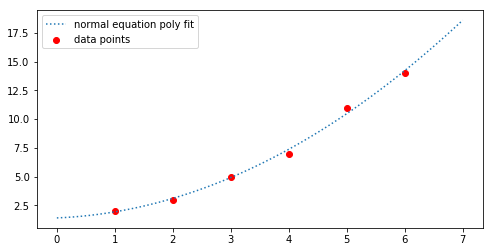

In [22]:
x = np.array([1, 2, 3, 4, 5, 6])
y = np.array([2, 3, 5, 7, 11, 14])
m = 2

# Create Vandermonde matrix A
A = create_vandermonde(x,2)

# Use linear algebra to solve least-squares problem and minimize || y - A z ||^2
z_hat = solve_linear_LS(A,y)

# Compute the minimum square error
delta = y-np.dot(A,z_hat)
mse = np.dot(delta,delta)/y.shape[0]

# Generate x/y plot points for the fitted polynomial
xx = np.linspace(0, 7)
yy = np.dot(create_vandermonde(xx,2),z_hat)

plt.figure(figsize=(8, 4))
plt.scatter(x, y, color='red', label='data points')
plt.plot(xx, yy, linestyle='dotted',label='normal equation poly fit')
plt.legend()

poly1_expr = ' + '.join(['{0:.4f} x^{1}'.format(v, i) for i, v in enumerate(z_hat)][::-1])[:-4]
print('normal equation polynomial fit is {0}'.format(poly1_expr))
print('normal equation MSE is {0:.4f}'.format(mse))

gradient descent polynomial fit is 0.3213 x^2 + 0.2078 x^1 + 1.3989
gradient descent MSE is 0.0810


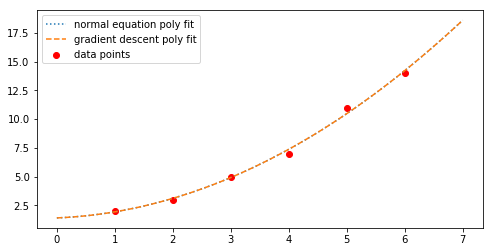

In [23]:
# Use gradient descent to solve least-squares problem and minimize || y - A z2 ||^2
z2_hat = solve_linear_LS_gd(A,y,0.0002,150000)

# Compute the minimum square error
delta = y-np.dot(A,z2_hat)
mse2 = np.dot(delta,delta)/y.shape[0]

# Generate y plot points for the gd fitted polynomial
yy2 = np.dot(create_vandermonde(xx,2),z2_hat)

plt.figure(figsize=(8, 4))
plt.scatter(x, y, color='red', label='data points')
plt.plot(xx, yy, linestyle='dotted',label='normal equation poly fit')
plt.plot(xx, yy2, linestyle='dashed', label='gradient descent poly fit')
plt.legend()

poly2_expr = ' + '.join(['{0:.4f} x^{1}'.format(v, i) for i, v in enumerate(z2_hat)][::-1])[:-4]
print('gradient descent polynomial fit is {0}'.format(poly2_expr))
print('gradient descent MSE is {0:.4f}'.format(mse2))

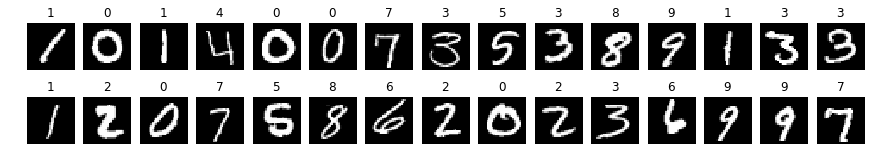

In [5]:
# read mnist csv file to a dataframe
df = pd.read_csv('mnist_train.csv')
# append feature column by merging all pixel columns
df['feature'] = df.apply(lambda row: row.values[1:], axis=1)
# only keep feature and label column
df = df[['feature', 'label']]
# display first 5 rows of the dataframe
df.head()

# Plot the first 30 images
plt.figure(figsize=(15, 2.5))
for i, row in df.iloc[:30].iterrows():
    x, y = row['feature'], row['label']
    plt.subplot(2, 15, i + 1)
    plt.imshow(x.reshape(28, 28), cmap='gray')
    plt.axis('off')
    plt.title(y)

Pairwise experiment, mapping 0 to -1, mapping 1 to 1
training error = 0.27%, testing error = 0.98%
Confusion matrix:
 [[2048   18]
 [  25 2317]]


array([0.00272232, 0.00975499])

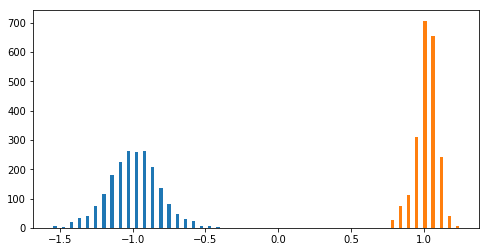

In [24]:
# Pairwise experiment for LSQ to classify between 0 and 1
mnist_pairwise_LS(df, 0, 1, verbose=True)

In [ ]:
from tqdm import tqdm_notebook as tqdm
num_trial, err_matrix = 1, np.zeros((10, 10))
for a, b in tqdm(it.combinations(range(10), 2), total=45):
    err_tr, err_te = np.mean([mnist_pairwise_LS(df, a, b) for _ in range(num_trial)], axis=0)
    err_matrix[a, b], err_matrix[b, a] = err_tr, err_te

print(np.round(err_matrix*100, 2))

In [25]:
def multi_extract_and_split(df, test_size=0.5):
    data = df.values
    
    x = []
    y = []
    for i in range(data.shape[0]):
        x.append(data[i][0])
        y.append(data[i][1])
    
    x = np.array(x)
    y = np.array(y)
    column = -1*np.ones(x.shape[0])
    x = np.column_stack((x,column))
    
    X_tr,X_te,y_tr,y_te = train_test_split(x,y,test_size=0.3,random_state=5)
    
    return X_tr, X_te, y_tr, y_te  

In [26]:
# Construct the training set and testting set
X_tr,X_te,y_tr,y_te = multi_extract_and_split(df, 0.5)

# Apply one-hot encoding to training labels
Y = np.zeros((X_tr.shape[0],10))
for i in range(y_tr.shape[0]):
    Y[i][y_tr[i]] = 1

# Run least-square on training set
Z = solve_linear_LS(X_tr,Y)

# Compute estimation and misclassification on training set
Y_hat_tr = np.dot(X_tr,Z)
y_hat_tr = []
for i in range(X_tr.shape[0]):
    max = 0
    for j in range(10):
        if Y_hat_tr[i][j]>Y_hat_tr[i][max]:
            max =j
    y_hat_tr.append(max)

y_hat_tr = np.array(y_hat_tr)
err_tr = err_tr = 1-accuracy_score(y_tr,y_hat_tr)

# Compute estimation and misclassification on training set
Y_hat_te = np.dot(X_te,Z)
y_hat_te = []
for i in range(X_te.shape[0]):
    max = 0
    for j in range(10):
        if Y_hat_te[i][j]>Y_hat_te[i][max]:
            max = j
    y_hat_te.append(max)
    
y_hat_te = np.array(y_hat_te)
err_te = 1-accuracy_score(y_te,y_hat_te)

print('training error = {0:.2f}%, testing error = {1:.2f}%'.format(100 * err_tr, 100 * err_te))
# Compute confusion matrix
cm = np.zeros((10, 10), dtype=np.int64)
for a in range(10):
    for b in range(10):
        cm[a, b] = ((y_te == a) & (y_hat_te == b)).sum()
print('Confusion matrix:\n {0}'.format(cm))

training error = 13.75%, testing error = 15.15%
Confusion matrix:
 [[1189    2    5    6    3    7   15    1    9    1]
 [   0 1348    8    5    6    3    2    2    9    3]
 [  24   50  958   40   26    4   49   30   37    5]
 [   6   38   35 1131    5   34   11   21   35   25]
 [   3   25   12    2 1058   16    8    4   12   68]
 [  37   22    4   99   30  801   43   13   49   26]
 [  26   22   20    1   27   20 1117    0   13    0]
 [   8   27   10    9   46    2    0 1165    4   78]
 [  13  110   10   45   24   45   11    4  899   29]
 [  19   10    3   33   85    2    0  109    9 1025]]
